# Problem 1

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load MNIST data
(train_images, _), (_, _) = mnist.load_data()
# Normalize images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=3)


11490434/11490434 [==============================] - 2s 0us/step


In [3]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [4]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', activation='tanh'))
    return model


In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model


In [6]:
# Discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Generator
generator = build_generator()

# GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


In [7]:
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
def train(gan, generator, discriminator, epochs, batch_size):
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        # Train discriminator with real images
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_imgs = train_images[idx]
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))

        # Train discriminator with fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Store losses
        d_losses.append((d_loss_real[0] + d_loss_fake[0]) / 2)
        g_losses.append(g_loss)

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {(d_loss_real[0]+d_loss_fake[0])/2} | G Loss: {g_loss}")

        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch, generator)

    return d_losses, g_losses


In [9]:
def plot_loss_curves(d_losses, g_losses):
    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


4/4 [==============================] - 0s 2ms/step
Epoch 1/100 | D Loss: 0.050672030076384544 | G Loss: 3.8902406692504883
4/4 [==============================] - 0s 2ms/step
Epoch 2/100 | D Loss: 0.06605417653918266 | G Loss: 4.120032787322998
4/4 [==============================] - 0s 2ms/step
Epoch 3/100 | D Loss: 0.06144414655864239 | G Loss: 4.361633777618408
4/4 [==============================] - 0s 2ms/step
Epoch 4/100 | D Loss: 0.07338190451264381 | G Loss: 3.9980056285858154
4/4 [==============================] - 0s 2ms/step
Epoch 5/100 | D Loss: 0.07521775364875793 | G Loss: 4.191866874694824
4/4 [==============================] - 0s 2ms/step
Epoch 6/100 | D Loss: 0.09710735455155373 | G Loss: 3.904996871948242
4/4 [==============================] - 0s 2ms/step
Epoch 7/100 | D Loss: 0.08550747856497765 | G Loss: 3.893592119216919
4/4 [==============================] - 0s 2ms/step
Epoch 8/100 | D Loss: 0.07822031155228615 | G Loss: 3.8876147270202637
4/4 [=======================

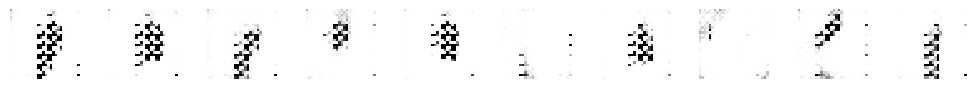

4/4 [==============================] - 0s 2ms/step
Epoch 11/100 | D Loss: 0.06994524039328098 | G Loss: 3.705620765686035
4/4 [==============================] - 0s 2ms/step
Epoch 12/100 | D Loss: 0.08701985329389572 | G Loss: 3.8011295795440674
4/4 [==============================] - 0s 2ms/step
Epoch 13/100 | D Loss: 0.06757417693734169 | G Loss: 3.944636583328247
4/4 [==============================] - 0s 2ms/step
Epoch 14/100 | D Loss: 0.08550380915403366 | G Loss: 3.5873990058898926
4/4 [==============================] - 0s 2ms/step
Epoch 15/100 | D Loss: 0.06215611286461353 | G Loss: 4.003246307373047
4/4 [==============================] - 0s 2ms/step
Epoch 16/100 | D Loss: 0.06648211181163788 | G Loss: 3.7345454692840576
4/4 [==============================] - 0s 2ms/step
Epoch 17/100 | D Loss: 0.0841733068227768 | G Loss: 3.7318649291992188
4/4 [==============================] - 0s 2ms/step
Epoch 18/100 | D Loss: 0.07568006590008736 | G Loss: 3.6521825790405273
4/4 [===============

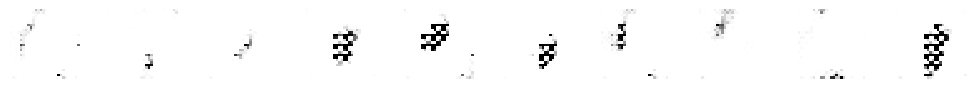

4/4 [==============================] - 0s 2ms/step
Epoch 21/100 | D Loss: 0.06024002283811569 | G Loss: 3.667990207672119
4/4 [==============================] - 0s 2ms/step
Epoch 22/100 | D Loss: 0.08357360772788525 | G Loss: 3.7358510494232178
4/4 [==============================] - 0s 2ms/step
Epoch 23/100 | D Loss: 0.07239390909671783 | G Loss: 3.7300262451171875
4/4 [==============================] - 0s 2ms/step
Epoch 24/100 | D Loss: 0.05928529426455498 | G Loss: 3.6545376777648926
4/4 [==============================] - 0s 2ms/step
Epoch 25/100 | D Loss: 0.08799563348293304 | G Loss: 3.3023650646209717
4/4 [==============================] - 0s 2ms/step
Epoch 26/100 | D Loss: 0.06377563625574112 | G Loss: 3.6043272018432617
4/4 [==============================] - 0s 2ms/step
Epoch 27/100 | D Loss: 0.1369444504380226 | G Loss: 3.2931432723999023
4/4 [==============================] - 0s 2ms/step
Epoch 28/100 | D Loss: 0.1208755224943161 | G Loss: 3.145266056060791
4/4 [===============

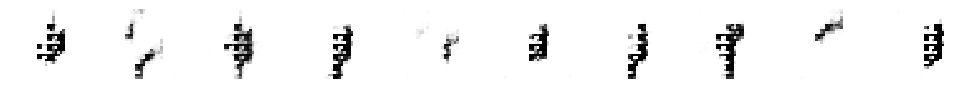

4/4 [==============================] - 0s 3ms/step
Epoch 31/100 | D Loss: 0.1483386904001236 | G Loss: 3.2734320163726807
4/4 [==============================] - 0s 2ms/step
Epoch 32/100 | D Loss: 0.1691214181482792 | G Loss: 2.927107810974121
4/4 [==============================] - 0s 2ms/step
Epoch 33/100 | D Loss: 0.18953292071819305 | G Loss: 2.55783748626709
4/4 [==============================] - 0s 2ms/step
Epoch 34/100 | D Loss: 0.19126661121845245 | G Loss: 2.978842258453369
4/4 [==============================] - 0s 2ms/step
Epoch 35/100 | D Loss: 0.18784701079130173 | G Loss: 3.0353846549987793
4/4 [==============================] - 0s 2ms/step
Epoch 36/100 | D Loss: 0.2245062217116356 | G Loss: 2.7247910499572754
4/4 [==============================] - 0s 2ms/step
Epoch 37/100 | D Loss: 0.2337343692779541 | G Loss: 2.3533053398132324
4/4 [==============================] - 0s 2ms/step
Epoch 38/100 | D Loss: 0.2540917843580246 | G Loss: 2.4288547039031982
4/4 [====================

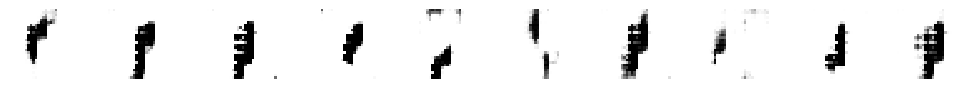

4/4 [==============================] - 0s 2ms/step
Epoch 41/100 | D Loss: 0.25136835128068924 | G Loss: 2.629854917526245
4/4 [==============================] - 0s 2ms/step
Epoch 42/100 | D Loss: 0.1909887194633484 | G Loss: 2.649876594543457
4/4 [==============================] - 0s 2ms/step
Epoch 43/100 | D Loss: 0.19407271593809128 | G Loss: 2.62459397315979
4/4 [==============================] - 0s 2ms/step
Epoch 44/100 | D Loss: 0.2215881124138832 | G Loss: 2.763430118560791
4/4 [==============================] - 0s 2ms/step
Epoch 45/100 | D Loss: 0.19329247623682022 | G Loss: 2.8956961631774902
4/4 [==============================] - 0s 2ms/step
Epoch 46/100 | D Loss: 0.17021669447422028 | G Loss: 3.026005506515503
4/4 [==============================] - 0s 2ms/step
Epoch 47/100 | D Loss: 0.20632293820381165 | G Loss: 2.732356548309326
4/4 [==============================] - 0s 2ms/step
Epoch 48/100 | D Loss: 0.18074125051498413 | G Loss: 2.591421365737915
4/4 [=====================

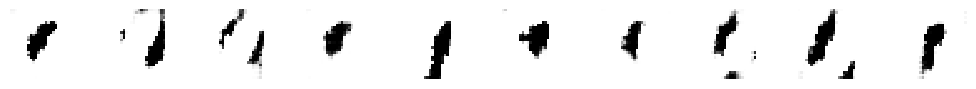

4/4 [==============================] - 0s 2ms/step
Epoch 51/100 | D Loss: 0.17615897208452225 | G Loss: 2.6715426445007324
4/4 [==============================] - 0s 2ms/step
Epoch 52/100 | D Loss: 0.17464972287416458 | G Loss: 2.501375198364258
4/4 [==============================] - 0s 2ms/step
Epoch 53/100 | D Loss: 0.19220944494009018 | G Loss: 2.5534744262695312
4/4 [==============================] - 0s 2ms/step
Epoch 54/100 | D Loss: 0.1823815405368805 | G Loss: 2.6372408866882324
4/4 [==============================] - 0s 2ms/step
Epoch 55/100 | D Loss: 0.19458874315023422 | G Loss: 2.8497273921966553
4/4 [==============================] - 0s 8ms/step
Epoch 56/100 | D Loss: 0.22700338065624237 | G Loss: 2.744622230529785
4/4 [==============================] - 0s 2ms/step
Epoch 57/100 | D Loss: 0.20913415402173996 | G Loss: 2.615354061126709
4/4 [==============================] - 0s 2ms/step
Epoch 58/100 | D Loss: 0.22178156673908234 | G Loss: 2.550666332244873
4/4 [================

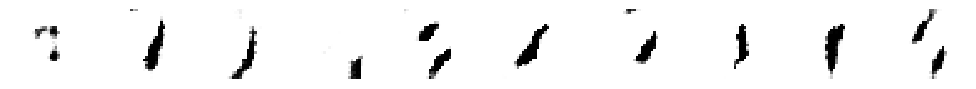

4/4 [==============================] - 0s 2ms/step
Epoch 61/100 | D Loss: 0.20047879964113235 | G Loss: 2.905930995941162
4/4 [==============================] - 0s 2ms/step
Epoch 62/100 | D Loss: 0.19017145037651062 | G Loss: 2.9540982246398926
4/4 [==============================] - 0s 2ms/step
Epoch 63/100 | D Loss: 0.2617279514670372 | G Loss: 2.716183662414551
4/4 [==============================] - 0s 2ms/step
Epoch 64/100 | D Loss: 0.17670803517103195 | G Loss: 2.5384573936462402
4/4 [==============================] - 0s 2ms/step
Epoch 65/100 | D Loss: 0.233492910861969 | G Loss: 2.554809331893921
4/4 [==============================] - 0s 2ms/step
Epoch 66/100 | D Loss: 0.2028425857424736 | G Loss: 2.8688368797302246
4/4 [==============================] - 0s 2ms/step
Epoch 67/100 | D Loss: 0.26286524534225464 | G Loss: 2.680569887161255
4/4 [==============================] - 0s 2ms/step
Epoch 68/100 | D Loss: 0.2835698574781418 | G Loss: 2.2122812271118164
4/4 [====================

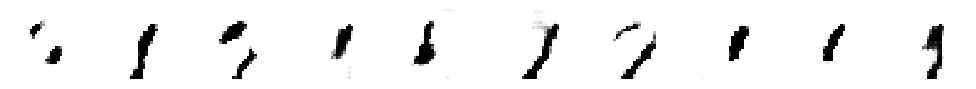

4/4 [==============================] - 0s 2ms/step
Epoch 71/100 | D Loss: 0.21276526898145676 | G Loss: 2.974705219268799
4/4 [==============================] - 0s 2ms/step
Epoch 72/100 | D Loss: 0.21429385244846344 | G Loss: 2.6100540161132812
4/4 [==============================] - 0s 2ms/step
Epoch 73/100 | D Loss: 0.2123369202017784 | G Loss: 2.7256157398223877
4/4 [==============================] - 0s 2ms/step
Epoch 74/100 | D Loss: 0.2706579118967056 | G Loss: 2.528613328933716
4/4 [==============================] - 0s 2ms/step
Epoch 75/100 | D Loss: 0.26982395350933075 | G Loss: 2.197309970855713
4/4 [==============================] - 0s 2ms/step
Epoch 76/100 | D Loss: 0.21416719257831573 | G Loss: 2.5042638778686523
4/4 [==============================] - 0s 2ms/step
Epoch 77/100 | D Loss: 0.2478393390774727 | G Loss: 2.8147706985473633
4/4 [==============================] - 0s 2ms/step
Epoch 78/100 | D Loss: 0.2321566939353943 | G Loss: 2.701521158218384
4/4 [===================

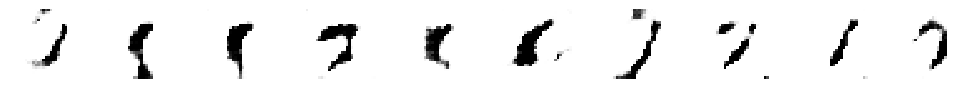

4/4 [==============================] - 0s 2ms/step
Epoch 81/100 | D Loss: 0.2949162498116493 | G Loss: 2.7195520401000977
4/4 [==============================] - 0s 2ms/step
Epoch 82/100 | D Loss: 0.2783188968896866 | G Loss: 2.4839649200439453
4/4 [==============================] - 0s 2ms/step
Epoch 83/100 | D Loss: 0.2456776425242424 | G Loss: 2.5550997257232666
4/4 [==============================] - 0s 2ms/step
Epoch 84/100 | D Loss: 0.26821283996105194 | G Loss: 2.791560649871826
4/4 [==============================] - 0s 2ms/step
Epoch 85/100 | D Loss: 0.3050956502556801 | G Loss: 2.606884479522705
4/4 [==============================] - 0s 2ms/step
Epoch 86/100 | D Loss: 0.285495787858963 | G Loss: 2.659940719604492
4/4 [==============================] - 0s 2ms/step
Epoch 87/100 | D Loss: 0.25107547640800476 | G Loss: 2.649671792984009
4/4 [==============================] - 0s 2ms/step
Epoch 88/100 | D Loss: 0.25514809787273407 | G Loss: 2.3872838020324707
4/4 [=====================

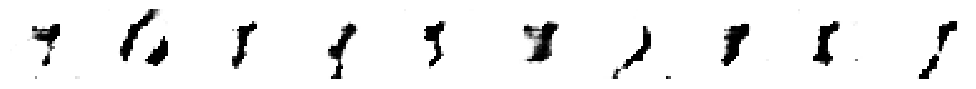

4/4 [==============================] - 0s 2ms/step
Epoch 91/100 | D Loss: 0.3590688109397888 | G Loss: 2.6122355461120605
4/4 [==============================] - 0s 2ms/step
Epoch 92/100 | D Loss: 0.2355513721704483 | G Loss: 2.7846906185150146
4/4 [==============================] - 0s 2ms/step
Epoch 93/100 | D Loss: 0.27120666950941086 | G Loss: 2.50348162651062
4/4 [==============================] - 0s 2ms/step
Epoch 94/100 | D Loss: 0.28743114322423935 | G Loss: 2.5367672443389893
4/4 [==============================] - 0s 2ms/step
Epoch 95/100 | D Loss: 0.3040136620402336 | G Loss: 2.0904316902160645
4/4 [==============================] - 0s 2ms/step
Epoch 96/100 | D Loss: 0.26045721769332886 | G Loss: 2.1559791564941406
4/4 [==============================] - 0s 2ms/step
Epoch 97/100 | D Loss: 0.2791007161140442 | G Loss: 2.34854793548584
4/4 [==============================] - 0s 2ms/step
Epoch 98/100 | D Loss: 0.28289932012557983 | G Loss: 2.382744312286377
4/4 [====================

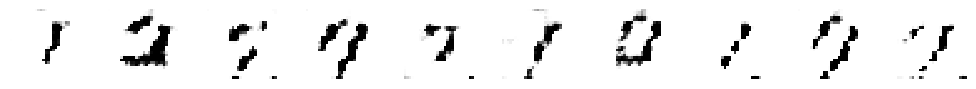

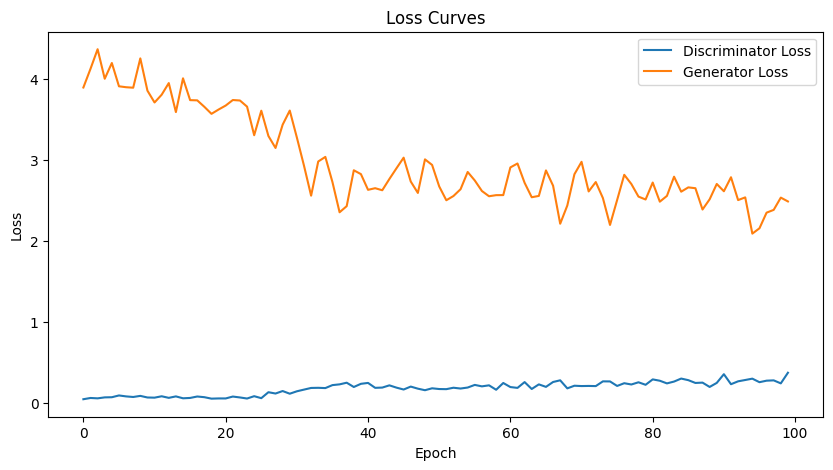

In [12]:
d_losses, g_losses = train(gan, generator, discriminator, epochs=100, batch_size=128)
plot_loss_curves(d_losses, g_losses)


1/1 [==============================] - 0s 49ms/step


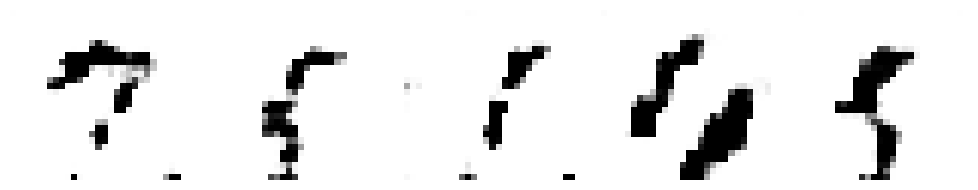

In [13]:
def generate_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(num_images, 28, 28)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_images(generator, num_images=5)


# Problem 2

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
import time
import matplotlib.pyplot as plt


##Problem 2a

In [ ]:
def create_dqn_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_shape, activation=None)
    ])
    return model

def create_dqn_model_large(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_shape, activation=None)
    ])
    return model

def create_dqn_model_small(input_shape, output_shape):
    model = tf.keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=input_shape),
        layers.Dense(output_shape, activation=None)
    ])
    return model


##Problem 2b

In [ ]:
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.

        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.

        Parameters
        ----------
        batch_size: int
            How many transitions to sample.

        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


## Problem 2c

In [ ]:
from re import VERBOSE
BUFFER_SIZE = 256
GAMMA = 0.99

env = gym.make('MountainCar-v0')
buffer = ReplayBuffer(BUFFER_SIZE)

def get_action(state, epsilon, model):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        Q_values = model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(Q_values[0])


def update_dqn_network(model, optimizer, buffer, batch_size):
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = buffer.sample(batch_size)
    Q_targets_next = model.predict(next_state_batch, verbose=0).max(axis=1)
    Q_targets = reward_batch + (GAMMA * Q_targets_next * (1 - done_batch))

    with tf.GradientTape() as tape:
        Q_expected = model(state_batch)
        Q_expected_relevant = tf.reduce_sum(Q_expected * tf.one_hot(action_batch, 3), axis=1)
        loss = tf.keras.losses.MSE(Q_expected_relevant, Q_targets)

    gradients = tape.gradient(loss, model.trainable_variables)
    #optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [ ]:
NUM_EPISODES = 1000
EPISODE_SIZE = 500
BATCH_SIZE = 128
EPS_MAX = 1.0
EPS_DECAY = 0.995

model = create_dqn_model((2,), 3)  # or create_dqn_model_large, create_dqn_model_small
optimizer = tf.keras.optimizers.Adam()
rewards = []
epsilon = EPS_MAX

for episode in range(NUM_EPISODES):
    start_time = time.time()  # Start time measurement
    episodic_reward = 0
    state = env.reset()
    state = np.array(state[0], dtype=np.float32)

    for t in range(EPISODE_SIZE):
        action = get_action(state, epsilon, model)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.array(next_state, dtype=np.float32)
        buffer.add(state, action, reward, next_state, done)
        episodic_reward += reward
        state = next_state

        if len(buffer) > BATCH_SIZE:
            update_dqn_network(model, optimizer, buffer, BATCH_SIZE)

        if done:
            break
    episode_duration = time.time() - start_time
    rewards.append(episodic_reward)
    epsilon *= EPS_DECAY
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Reward: {episodic_reward}, Time: {episode_duration:.2f} seconds")


plt.plot(rewards)
plt.title('Reward Curve')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()


Episode 1/1000, Reward: -500.0, Time: 25.49 seconds
Episode 2/1000, Reward: -500.0, Time: 29.57 seconds
Episode 3/1000, Reward: -500.0, Time: 28.46 seconds
Episode 4/1000, Reward: -500.0, Time: 29.83 seconds
Episode 5/1000, Reward: -500.0, Time: 28.79 seconds
Episode 6/1000, Reward: -500.0, Time: 29.28 seconds
Episode 7/1000, Reward: -500.0, Time: 28.24 seconds
Episode 8/1000, Reward: -500.0, Time: 29.18 seconds
Episode 9/1000, Reward: -500.0, Time: 28.80 seconds
Episode 10/1000, Reward: -500.0, Time: 30.56 seconds
Episode 11/1000, Reward: -500.0, Time: 29.54 seconds
Episode 12/1000, Reward: -500.0, Time: 31.04 seconds
Episode 13/1000, Reward: -500.0, Time: 29.42 seconds
Episode 14/1000, Reward: -500.0, Time: 30.88 seconds
Episode 15/1000, Reward: -500.0, Time: 29.67 seconds
Episode 16/1000, Reward: -500.0, Time: 31.46 seconds
Episode 17/1000, Reward: -500.0, Time: 30.69 seconds
Episode 18/1000, Reward: -500.0, Time: 31.60 seconds
Episode 19/1000, Reward: -500.0, Time: 30.49 seconds
Ep